### Load all simulation complexes

Load all simulation complexes.


In [1]:
import os
from tqdm.notebook import tqdm
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

simdir = "/home/admin/gitrepos/gromacs_sims/Antimicrobial_Peptides/Pseudomonas_antibiotics/simulation"
data_dirnames = ["old_simulations", "new_simulation_complexes_param","new_parc_simulation_complexes_kuhpchn"]
simulation_dirs = []
for dirname in data_dirnames:
    data_dir = os.path.join(simdir, dirname)
    try:
        for entry in sorted(os.listdir(data_dir)):
            if 'pdb' in entry.lower():
                continue
            fullpath = os.path.join(data_dir, entry)
            if os.path.isdir(fullpath):
                simulation_dirs.append(fullpath)
    except FileNotFoundError:
        # skip missing data_dir
        continue


In [2]:
len(simulation_dirs)

36

Prepare protlig tpr selections for each complex (unless it already exists from old PP)

In [3]:
import subprocess
import glob
import re


for sys in simulation_dirs:
    complex_name = os.path.basename(sys)
    print(complex_name)
    xtc_files = glob.glob(os.path.join(sys, '*_cluster_center_traj.xtc'))
    if not xtc_files:
        print(f"No cluster_center_traj.xtc found in {sys}, skipping...")
        continue

    xtc_file = xtc_files[0]
    m = re.search(r'([^_/\\]+)_cluster_center_traj\.xtc$', os.path.basename(xtc_file))
    if not m:
        print(f"Couldn't parse ligand name from {xtc_file}, skipping...")
        continue

    ligname = m.group(1)
    tpr_file = os.path.join(sys, f"prot_{complex_name}_{ligname}_gppmd.tpr")
    index_file = os.path.join(sys, f"prot_{complex_name}_{ligname}_index.ndx")
    out_tpr = os.path.join(sys, f"prot_{complex_name}_{ligname}_protlig.tpr")
    selection_str = "Protein_Other"
    if os.path.exists(out_tpr):
        print(f"protlig tpr already exists for {complex_name}, skipping...")
        continue
    # try the plain gmx binary first, fall back to gmx_mpi if needed
    gmxbinary = "gmx"
    cmd = [gmxbinary, "convert-tpr", "-s", tpr_file,"-n", index_file, "-o", out_tpr]
    print(f"Running command: {' '.join(cmd)}")
    try:
        # Many gmx commands accept interactive input; provide the selection string on stdin.
        # ensure a newline so the program receives the entry as if typed.
        try:
            # Source GMXRC in a bash login shell and capture the resulting environment,
            # then merge it into the current process environment so "gmx" is available.
            res = subprocess.run(
                ["bash", "-lc", "source /usr/local/gromacs/bin/GMXRC >/dev/null 2>&1 && env -0"],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True,
                check=True,
            )
            for kv in res.stdout.split("\0"):
                if not kv:
                    continue
                k, v = kv.split("=", 1)
                os.environ[k] = v
        except subprocess.CalledProcessError as exc:
            print(f"Warning: could not source GMXRC: {exc.stderr.strip()}")
        proc = subprocess.run(cmd, input=selection_str + "\n", text=True,
                            stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    except (subprocess.CalledProcessError, FileNotFoundError) as exc:
        # try next binary if first fails, otherwise raise after last attempt
        last_exc = exc
        continue

aminostep2012C
protlig tpr already exists for aminostep2012C, skipping...
aminostep2016C
protlig tpr already exists for aminostep2016C, skipping...
aminotob2016C
protlig tpr already exists for aminotob2016C, skipping...
levgyra2018C
protlig tpr already exists for levgyra2018C, skipping...
levparc2018C_chainB
protlig tpr already exists for levparc2018C_chainB, skipping...
ndxgyra1996C
protlig tpr already exists for ndxgyra1996C, skipping...
ndxgyra2018C
protlig tpr already exists for ndxgyra2018C, skipping...
ndxparc1999C_chainB
protlig tpr already exists for ndxparc1999C_chainB, skipping...
ndxparc2018C_chainA
protlig tpr already exists for ndxparc2018C_chainA, skipping...
pbpmez2018C
protlig tpr already exists for pbpmez2018C, skipping...
pbppen1999C
protlig tpr already exists for pbppen1999C, skipping...
pbppen2018C
protlig tpr already exists for pbppen2018C, skipping...
aminoneo2012C
protlig tpr already exists for aminoneo2012C, skipping...
aminoneo2016C
protlig tpr already exists f

Now, prepare MDAnalysis universes for each complex

In [4]:
complexes = {}

for dir in tqdm(simulation_dirs):
    complex_name = os.path.basename(dir)
    topol_file = [f for f in os.listdir(os.path.join(data_dir, dir)) if f.endswith('protlig.tpr')][0]
    traj_file = [f for f in os.listdir(os.path.join(data_dir, dir)) if f.endswith('cluster_center_traj.xtc')][0]
    complexes[complex_name] = mda.Universe(os.path.join(data_dir, dir, topol_file),
                                os.path.join(data_dir, dir, traj_file))

  0%|          | 0/36 [00:00<?, ?it/s]

### Calculate all RMSD values and load in a dataframe

Using nproc=36


  0%|          | 0/36 [00:00<?, ?it/s]

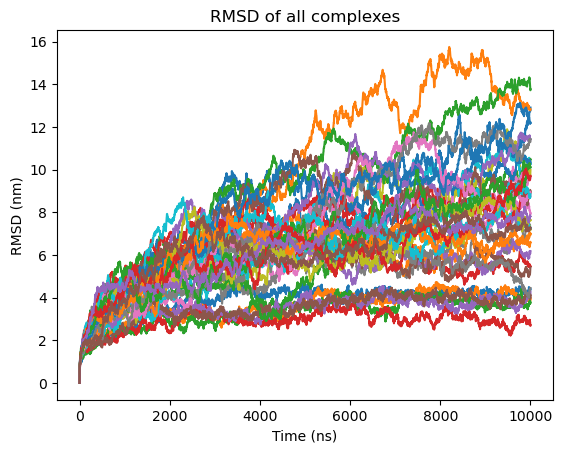

In [5]:
from multiprocessing import Pool, cpu_count
import os
import pandas as pd

def _compute_rmsd_task(args):
    complexname, topol_path, traj_path = args
    import MDAnalysis as mda
    from MDAnalysis.analysis import rms
    u = mda.Universe(topol_path, traj_path)
    R = rms.RMSD(u, u, select='backbone', ref_frame=0)
    R.run(verbose=False)
    times = R.results.rmsd[:, 1]
    rmsd = R.results.rmsd[:, 2]
    return complexname, times, rmsd

# Build list of (name, topol_path, traj_path) so worker processes don't need non-picklable Universe objects
tasks = []

for d in simulation_dirs:
    topol_file = [f for f in os.listdir(os.path.join(data_dir, d)) if f.endswith('protlig.tpr')][0]
    traj_file = [f for f in os.listdir(os.path.join(data_dir, d)) if f.endswith('cluster_center_traj.xtc')][0]
    tasks.append((os.path.basename(d), os.path.join(data_dir, d, topol_file), os.path.join(data_dir, d, traj_file)))

rmsd_df = None
# If SLURM_CPUS_PER_TASK is set, use it (fall back to previously computed nproc)
slurm_cpus = os.environ.get('SLURM_CPUS_PER_TASK')
if slurm_cpus:
    try:
        nproc_env = int(slurm_cpus)
        if nproc_env > 0:
            nproc = nproc_env
    except ValueError:
        pass

# Ensure we don't request more processes than logical CPUs
nproc = max(1, min(nproc, cpu_count()))

print(f"Using nproc={nproc}")
with Pool(processes=nproc) as pool:
    for complexname, times, rmsd in tqdm(pool.imap_unordered(_compute_rmsd_task, tasks), total=len(tasks)):
        if rmsd_df is None:
            rmsd_df = pd.DataFrame({'Time': times})
        rmsd_df[complexname] = rmsd

# Prepare and display the plot.
rmsd_df.set_index('Time', inplace=True)
rmsd_df.plot(legend=False)
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (nm)')
plt.title('RMSD of all complexes')
#plt.legend(title='Complex')
plt.show()


In [6]:
rmsd_df.head()

,aminostep2012C,aminoneo2016C,aminostep2016C,aminoneo2012C,aminotob2016C,aminotob2012C,ndxgyra2007C,ndxparc2018C_chainA,ndxparc1999C_chainB,pbppen2018C,...,levparc2014C,levparc1999C,cipparc2007C,ndxparc2015C,cipparc2015C,norgyra2018C,cipparc1999C,ndxparc2014C,levgyra2007C,levgyra1996C
Time,,,,,,,,,,,,,,,,,,,,,
0.0,7.812190e-07,0.000001,0.000000,8.734294e-07,5.524053e-07,0.000001,0.000001,0.000002,0.000003,0.000003,...,0.000003,0.000003,0.000005,0.000006,0.000004,7.111549e-07,0.000002,0.000003,0.000000,0.000003
2.0,5.749667e-01,0.547769,0.578932,6.750454e-01,5.916681e-01,0.614920,0.632039,0.651700,0.636217,0.681516,...,0.647382,0.631592,0.696673,0.623967,0.624079,6.429394e-01,0.668858,0.643126,0.620612,0.655154
4.0,6.735981e-01,0.701199,0.657709,6.940576e-01,6.757049e-01,0.692258,0.743318,0.743957,0.727482,0.814197,...,0.787686,0.723768,0.794905,0.746196,0.714149,7.503168e-01,0.765837,0.785315,0.715648,0.797031
6.0,7.794069e-01,0.721216,0.743575,7.489145e-01,7.385371e-01,0.741944,0.821358,0.792326,0.842502,0.921890,...,0.884499,0.835448,0.850743,0.867082,0.817974,8.047810e-01,0.869013,0.845998,0.786877,0.878471
8.0,8.204279e-01,0.689628,0.779477,7.700368e-01,7.587947e-01,0.818813,0.899265,0.868050,0.859788,1.006266,...,1.023763,0.896182,0.896954,0.976021,0.899073,9.439475e-01,0.986805,0.965409,0.886468,0.890349


### Calculate all RMSF and load in a dictionary

In [7]:
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import numpy as _np

# build tasks: (complexname, topol_path, traj_path)
tasks = []
for complexname in complexes.keys():
    dirpath = next((d for d in simulation_dirs if os.path.basename(d) == complexname), None)
    if dirpath is None:
        continue
    try:
        topol_file = [f for f in os.listdir(dirpath) if f.endswith('protlig.tpr')][0]
        traj_file = [f for f in os.listdir(dirpath) if f.endswith('cluster_center_traj.xtc')][0]
    except IndexError:
        # skip if files not found
        continue
    tasks.append((complexname, os.path.join(dirpath, topol_file), os.path.join(dirpath, traj_file)))

# worker (override previous broken definition)
def _compute_rmsf_task(args):
    complexname, topol_path, traj_path = args

    u = mda.Universe(topol_path, traj_path)
    sel = u.select_atoms('backbone and name CA')
    R = rms.RMSF(sel).run(verbose=False)
    resids = _np.array(sel.resids)
    rmsf = _np.array(R.results.rmsf)
    return complexname, resids, rmsf

# run in parallel and collect results
rmsf_dict = {}
with Pool(processes=nproc) as p:
    for complexname, resids, rmsf in tqdm(p.imap_unordered(_compute_rmsf_task, tasks), total=len(tasks)):
        rmsf_dict[f'{complexname}_resid'] = resids
        rmsf_dict[f'{complexname}_rmsf'] = rmsf

  0%|          | 0/36 [00:00<?, ?it/s]

### Calculate all Radii of Gyration and load in a dataframe 

  0%|          | 0/36 [00:00<?, ?it/s]

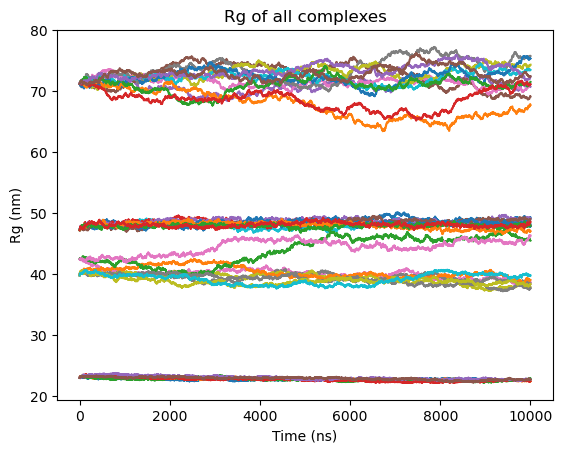

In [8]:
import pandas as pd
from MDAnalysis.analysis import rms
import MDAnalysis as mda
import numpy as _np
# build tasks list of (complexname, topol_path, traj_path) so worker processes create their own Universe
rg_tasks = []
for d in simulation_dirs:
    complexname = os.path.basename(d)
    try:
        topol_file = [f for f in os.listdir(d) if f.endswith('protlig.tpr')][0]
        traj_file = [f for f in os.listdir(d) if f.endswith('cluster_center_traj.xtc')][0]
    except IndexError:
        # skip directories missing required files
        continue
    rg_tasks.append((complexname, os.path.join(d, topol_file), os.path.join(d, traj_file)))

def _compute_rg_task(args):
    complexname, topol_path, traj_path = args
    u = mda.Universe(topol_path, traj_path)
    group = u.select_atoms('protein')
    times = []
    rg = []
    for ts in u.trajectory:
        times.append(ts.time)
        rg.append(group.radius_of_gyration())
    return complexname, _np.array(times), _np.array(rg)

rg_df = None
with Pool(processes=nproc) as pool:
    for complexname, times_arr, rg_arr in tqdm(pool.imap_unordered(_compute_rg_task, rg_tasks), total=len(rg_tasks)):
        if rg_df is None:
            rg_df = pd.DataFrame({'Time': times_arr})
        rg_df[complexname] = rg_arr

# Prepare and display the plot.
rg_df.set_index('Time', inplace=True)
rg_df.plot(legend=False)
plt.xlabel('Time (ns)')
plt.ylabel('Rg (nm)')
plt.title('Rg of all complexes')
plt.show()

### Number of hydrogen bonds between protein and ligand

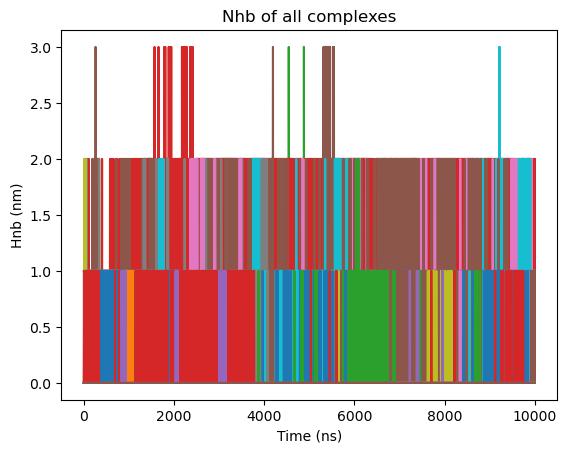

In [10]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd
import os
from multiprocessing import Pool
import numpy as _np
import MDAnalysis as mda
import warnings
import logging
warnings.filterwarnings("ignore")

logging.getLogger("MDAnalysis").setLevel(logging.ERROR)
logging.getLogger("matplotlib").setLevel(logging.ERROR)

# suppress numpy runtime warnings (e.g. divide by zero, invalid)
_np.seterr(all='ignore')
hb_dict = {}
# build tasks: (complexname, topol_path, traj_path)
tasks_hb = []
for complexname in list(complexes.keys()):
    dirpath = next((d for d in simulation_dirs if os.path.basename(d) == complexname), None)
    if dirpath is None:
        continue
    try:
        topol_file = [f for f in os.listdir(dirpath) if f.endswith('protlig.tpr')][0]
        traj_file = [f for f in os.listdir(dirpath) if f.endswith('cluster_center_traj.xtc')][0]
    except IndexError:
        continue
    tasks_hb.append((complexname, os.path.join(dirpath, topol_file), os.path.join(dirpath, traj_file)))

# Temporarily prevent the serial loop below from executing by emptying complexes,
# we'll restore it after the parallel work.
_orig_complexes = complexes
complexes = {}

def _hba_worker(args):
    complexname, topol_path, traj_path = args

    u = mda.Universe(topol_path, traj_path)
    hbs = HBA(universe=u, update_selections=False)
    hbs.donors_sel = hbs.guess_donors("protein")
    hbs.hydrogens_sel = hbs.guess_hydrogens("protein")
    hbs.acceptors_sel = hbs.guess_acceptors("not protein")
    hbs.run(verbose=False)
    ligand_indices = u.select_atoms(hbs.acceptors_sel).indices

    hbs_reversed = HBA(universe=u, update_selections=False)
    hbs_reversed.donors_sel = hbs.guess_donors("not protein")
    hbs_reversed.hydrogens_sel = hbs.guess_hydrogens("not protein")
    hbs_reversed.acceptors_sel = hbs.guess_acceptors("protein")
    hbs_reversed.run(verbose=False)

    # filter to intermolecular bonds (protein <-> ligand)
    filtered = []
    for hb in hbs.results.hbonds:
        frame, donor_idx, hydrogen_idx, acceptor_idx, da_dist, da_angle = hb
        if (donor_idx not in ligand_indices and acceptor_idx in ligand_indices) or \
        (donor_idx in ligand_indices and acceptor_idx not in ligand_indices):
            filtered.append(hb)

    for hb in hbs_reversed.results.hbonds:
        frame, donor_idx, hydrogen_idx, acceptor_idx, da_dist, da_angle = hb
        if (donor_idx not in ligand_indices and acceptor_idx in ligand_indices) or \
        (donor_idx in ligand_indices and acceptor_idx not in ligand_indices):
            filtered.append(hb)

    filtered = np.array(filtered)

    # counts per frame (nhb)
    times = hbs.times
    if filtered.size == 0:
        nhb = _np.zeros_like(times, dtype=int)
    else:
        frames = filtered[:, 0].astype(int)
        nhb = _np.bincount(frames, minlength=len(times))[:len(times)]

    n_frames = hbs.n_frames

    # counts by (donor, hydrogen, acceptor)
    if filtered.size == 0:
        count_ids = _np.empty((0, 4), dtype=int)
    else:
        ids = filtered[:, 1:4].astype(int)
        uniq, counts = _np.unique(ids, axis=0, return_counts=True)
        count_ids = _np.hstack((uniq, counts.reshape(-1, 1))).astype(int)

    return complexname, {
        "hbonds": filtered,
        "times": times,
        "nhb": nhb,
        "n_frames": n_frames,
        "count_ids": count_ids,
    }

# Run workers and build hb_dict with lightweight stubs compatible with later code
hb_dict = {}
with Pool(processes=nproc) as pool:
    for complexname, data in pool.imap_unordered(_hba_worker, tasks_hb):
        class _HBAStub:
            def __init__(self, d):
                self.results = type("R", (), {})()
                self.results.hbonds = d["hbonds"]
                self.times = d["times"]
                self.n_frames = d["n_frames"]
                self._nhb = d["nhb"]
                self._count_ids = d["count_ids"]
            def count_by_time(self):
                return self._nhb
            def count_by_ids(self):
                return self._count_ids

        hb_dict[complexname] = _HBAStub(data)
# Restore complexes dictionary for potential later use
complexes = _orig_complexes
nhb_df = None
for complexname, hbs in hb_dict.items():
    times = hbs.times
    nhb = hbs.count_by_time()
    # For the first complex, initialize the DataFrame with the time column.
    if nhb_df is None:
        nhb_df = pd.DataFrame({'Time': times})
        
    # Add the RMSD values for the current complex to the DataFrame.
    nhb_df[complexname] = nhb
# Prepare and display the plot.
# Prepare and display the plot.
nhb_df.set_index('Time', inplace=True)
nhb_df.plot(legend=False)
plt.xlabel('Time (ns)')
plt.ylabel('Hnb (nm)')
plt.title('Nhb of all complexes')
plt.show()

In [11]:
from IPython.display import display

# find and show columns in nhb_df that contain only zeros
try:
    nhb_df  # ensure variable exists
except NameError:
    print("nhb_df is not defined in the current notebook.")
else:
    zero_cols = [c for c in nhb_df.columns if nhb_df[c].eq(0).all()]
    if not zero_cols:
        print("No columns contain only zeros.")
    else:
        print(f"Columns with all zeros ({len(zero_cols)}):")
        for name in zero_cols:
            print(" -", name)
        # display the data for those columns (useful in Jupyter)
        try:
            display(nhb_df[zero_cols])
        except Exception:
            print(nhb_df[zero_cols].head())

Columns with all zeros (2):
 - aminostep2012C
 - cipparc2018C


,aminostep2012C,cipparc2018C
Time,,
0.0,0,0
2.0,0,0
4.0,0,0
6.0,0,0
8.0,0,0
...,...,...
9992.0,0,0
9994.0,0,0
9996.0,0,0


### Plot everything

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.axes as maxes
_original_axis = maxes.Axes.axis

def new_axis(self, *args, **kwargs):
    if args and args[0] == 'off':
        return self  # Skip turning off the axes
    return _original_axis(self, *args, **kwargs)

maxes.Axes.axis = new_axis

colors={'rmsd':'blue', 'rg':'green', 'rmsf':'orange', 'nhb':'gray'}
linestyles={'rmsd':'-', 'rg':'-.', 'rmsf':'--', 'nhb':'-'}
lw = 3
def add_plot(complexname, dataframe, axis, top_dict, right_df ,legend=False, top_ticklabel=False, right_ticklabel=False):
    axis.plot(dataframe.index/1000, dataframe[complexname], label="RMSD (nm)", color=colors['rmsd'], linestyle=linestyles['rmsd'], lw=lw)
    axis.plot(rg_df.index/1000, rg_df[complexname], label=r"$R_g$ (nm)", color=colors['rg'], linestyle=linestyles['rg'], lw=lw)
    axis.set_xticks(dataframe.index[::int(len(dataframe)/4)]/1000)
    axis.set_xticklabels(dataframe.index[::int(len(dataframe)/4)]/1000)
    
    ax_top = axis.twiny()
    ax_top.plot(top_dict[f"{complexname}_resid"], top_dict[f"{complexname}_rmsf"], label="RMSF (nm)", color=colors['rmsf'], linestyle=linestyles['rmsf'])
    ticks = np.linspace(top_dict[f"{complexname}_resid"][0], top_dict[f"{complexname}_resid"][-1], 4)
    ax_top.set_xticks(ticks)
    ax_top.tick_params(axis='both', which='both', direction='in', length=12, width=2.5)
    if top_ticklabel:
        ax_top.set_xlabel("Resid", fontsize=12)
        ax_top.set_xticklabels(["{:.0f}".format(x) for x in ticks])
    else:
        ax_top.set_xticklabels([])

    ax_right = axis.twinx()
    ax_right.plot(right_df.index/1000, right_df[complexname], label=r"$N_{hb}$", color=colors['nhb'], alpha=0.5, linestyle=linestyles['nhb'], lw=lw)
    ax_right.set_ylim(0, 3.1)
    ticks = [0,1,2,3]
    ax_right.set_yticks(ticks)
    ax_right.tick_params(axis='both', which='both', direction='in', length=12, width=2.5)
    if right_ticklabel:
        ax_right.set_yticklabels(["{:.0f}".format(x) for x in ticks])
        ax_right.set_ylabel(r"$N_{hb}$", fontsize=12)
    else:
        ax_right.set_yticklabels([])

    if legend:
        lines, labels = axis.get_legend_handles_labels()
        top_lines, top_labels = ax_top.get_legend_handles_labels()
        right_lines, right_labels = ax_right.get_legend_handles_labels()
        axis.legend(lines + top_lines + right_lines, labels + top_labels + right_labels, 
                    loc='upper center', fontsize=10, title_fontsize=10, ncol=4)
        
        lgd = axis.get_legend()
        lgd.set_bbox_to_anchor((0.5, 1.6))
        lgd.get_frame().set_alpha(1.0)



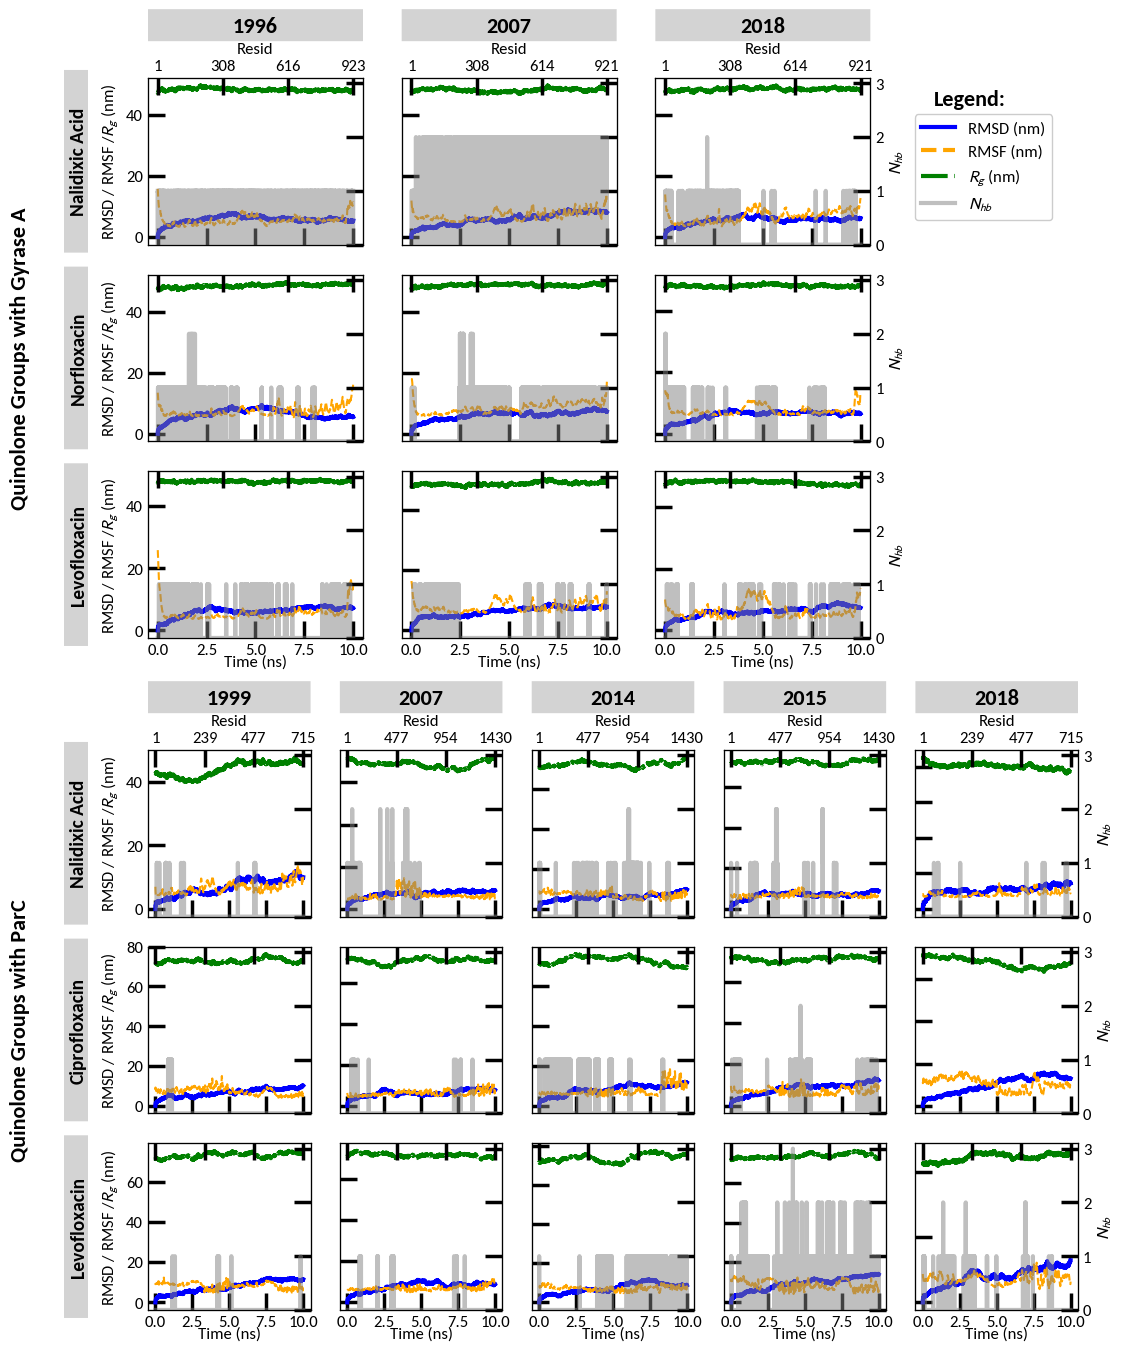

In [13]:
# language: python
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['axes.titlepad'] = 0
mpl.rcParams['font.family'] = 'Carlito'
mpl.rcParams['font.serif'] = ['Carlito']
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'stixsans'
mpl.rcParams['text.usetex'] = False
from matplotlib.patches import FancyBboxPatch
from matplotlib import lines as mlines

fig = plt.figure(figsize=(12, 16), constrained_layout=True)
# Outer: left main area + right legend column
outer = GridSpec(nrows=2, ncols=2, width_ratios=[8, 2], wspace=0.06)

# Right legend / annotation column
legend_ax = fig.add_subplot(outer[0, 1])
legend_ax.cla()
legend_ax.set_axis_off()
legend_ax.text(0.2, 0.98, "Legend:", va='top', fontsize=16, weight='bold')
handles = [
    mlines.Line2D([0], [0], color=colors['rmsd'], lw=lw, linestyle=linestyles['rmsd']),
    mlines.Line2D([0], [0], color=colors['rmsf'], lw=lw, linestyle=linestyles['rmsf']),
    mlines.Line2D([0], [0], color=colors['rg'], lw=lw, linestyle=linestyles['rg']),
    mlines.Line2D([0], [0], color=colors['nhb'], lw=lw, alpha=0.5, linestyle=linestyles['nhb']),
]
labels = ["RMSD (nm)", "RMSF (nm)", r"$R_g$ (nm)", r"$N_{hb}$"]

leg = legend_ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.05, 0.95),
                    frameon=True, fontsize=12, title=None)
leg.get_frame().set_alpha(1.0)


top_gs = outer[0, 0].subgridspec(nrows=3, ncols=3, hspace=0.18, wspace=0.18)
# Top block: 3 rows × 3 cols
top_axes = [[fig.add_subplot(top_gs[r, c]) for c in range(3)] for r in range(3)]

# Column headers for top block
top_years = ['1996', '2007', '2018']
for j, year in enumerate(top_years):
    pos = top_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.026
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

#Formatting for top block axes
for r in range(3):
    for c in range(3):
        ax = top_axes[r][c]
        # make ticks point inward and enable ticks on top/right (still control label visibility below)
        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False, length=12, width=2.5)
        # disable minor ticks on both axes
        ax.minorticks_off()
        # hide axis label text (tick labels) but keep tick marks
        if r == 2:
            ax.tick_params(axis='x', which='both', labelbottom=True)
            ax.xaxis.set_label_coords(0.5, -0.1)
            ax.set_xlabel('Time (ns)', fontsize=12)
        else:
            ax.tick_params(axis='x', which='both', labelbottom=False)    
        if c == 0:
            ax.tick_params(axis='y', which='both', labelleft=True)
        else:
            ax.tick_params(axis='y', which='both', labelleft=False)
        #ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# Vertical group labels (left side)
top_block_pos = top_axes[1][0].get_position()  # middle row of top block
# compute vertical centers from actual axes positions (fixes AttributeError)
top_positions = [top_axes[r][c].get_position() for r in range(len(top_axes)) for c in range(len(top_axes[0]))]
top_y0 = min(p.y0 for p in top_positions)
top_y1 = max(p.y1 for p in top_positions)
top_center = (top_y0 + top_y1) / 2
fig.text(0.01, top_center, "Quinolone Groups with Gyrase A",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')

Ligand_names = ["Nalidixic Acid", "Norfloxacin", "Levofloxacin"]
for i, name in enumerate(Ligand_names):
    pos = top_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.07, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.07, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.065, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')


#Data plots for top axes
ndxgyra_complexes = [name for name in complexes.keys() if 'ndxgyra' in name.lower()]
for i, cmplx, ax in zip(range(len(top_axes[0])), sorted(ndxgyra_complexes), top_axes[0]):
    setlabel = (i == len(top_axes[0]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel, top_ticklabel=True)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")
    
norgyra_complexes = [name for name in complexes.keys() if 'norgyra' in name.lower()]
for i, cmplx, ax in zip(range(len(top_axes[1])), sorted(norgyra_complexes), top_axes[1]):
    setlabel = (i == len(top_axes[1]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")


levgyra_complexes = [name for name in complexes.keys() if 'levgyra' in name.lower()]
for i, cmplx, ax in zip(range(len(top_axes[2])), sorted(levgyra_complexes), top_axes[2]):
    setlabel = (i == len(top_axes[2]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")



# Bottom block: 3 rows × 5 cols
# make the bottom block span the full figure width (both left and legend columns)
bot_gs = outer[1, :].subgridspec(nrows=3, ncols=5, hspace=0.18, wspace=0.18)
bot_axes = [[fig.add_subplot(bot_gs[r, c]) for c in range(5)] for r in range(3)]

# Column headers for bottom block
bot_years = ['1999', '2007', '2014', '2015', '2018']
for j, year in enumerate(bot_years):
    pos = bot_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.026
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

for r in range(3):
    for c in range(5):
        ax = bot_axes[r][c]
        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False, length=12, width=2.5)
        ax.minorticks_off()
        # hide axis label text (tick labels) but keep tick marks
        if r == 2:
            ax.tick_params(axis='x', which='both', labelbottom=True)
            # raise x-label a bit (move it slightly closer to the axis)
            ax.xaxis.set_label_coords(0.5, -0.1)
            ax.set_xlabel('Time (ns)', fontsize=12)
        else:
            ax.tick_params(axis='x', which='both', labelbottom=False)
        if c == 0:
            ax.tick_params(axis='y', which='both', labelleft=True)
        else:
            ax.tick_params(axis='y', which='both', labelleft=False)
        #ax.tick_params(axis='both', which='both', labelbottom=False, labelleft


bot_block_pos = bot_axes[1][0].get_position()  # middle row of bottom block
bot_positions = [bot_axes[r][c].get_position() for r in range(len(bot_axes)) for c in range(len(bot_axes[0]))]
bot_y0 = min(p.y0 for p in bot_positions)
bot_y1 = max(p.y1 for p in bot_positions)
bot_center = (bot_y0 + bot_y1) / 2
fig.text(0.01, bot_center, "Quinolone Groups with ParC",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')


Ligand_names = ["Nalidixic Acid", "Ciprofloxacin", "Levofloxacin"]
for i, name in enumerate(Ligand_names):
    pos = bot_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.07, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.07, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.065, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')

ndxparc_complexes = [name for name in complexes.keys() if 'ndxparc' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[0])), sorted(ndxparc_complexes), bot_axes[0]):
    setlabel = (i == len(bot_axes[0]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel, top_ticklabel=True)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")

cipparc_complexes = [name for name in complexes.keys() if 'cipparc' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[1])), sorted(cipparc_complexes), bot_axes[1]):
    setlabel = (i == len(bot_axes[1]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")

levparc_complexes = [name for name in complexes.keys() if 'levparc' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[2])), sorted(levparc_complexes), bot_axes[2]):
    setlabel = (i == len(bot_axes[2]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")


plt.savefig("pseudomonas_antibiotics_gyra_parc.svg", dpi=300, bbox_inches='tight')
plt.show()

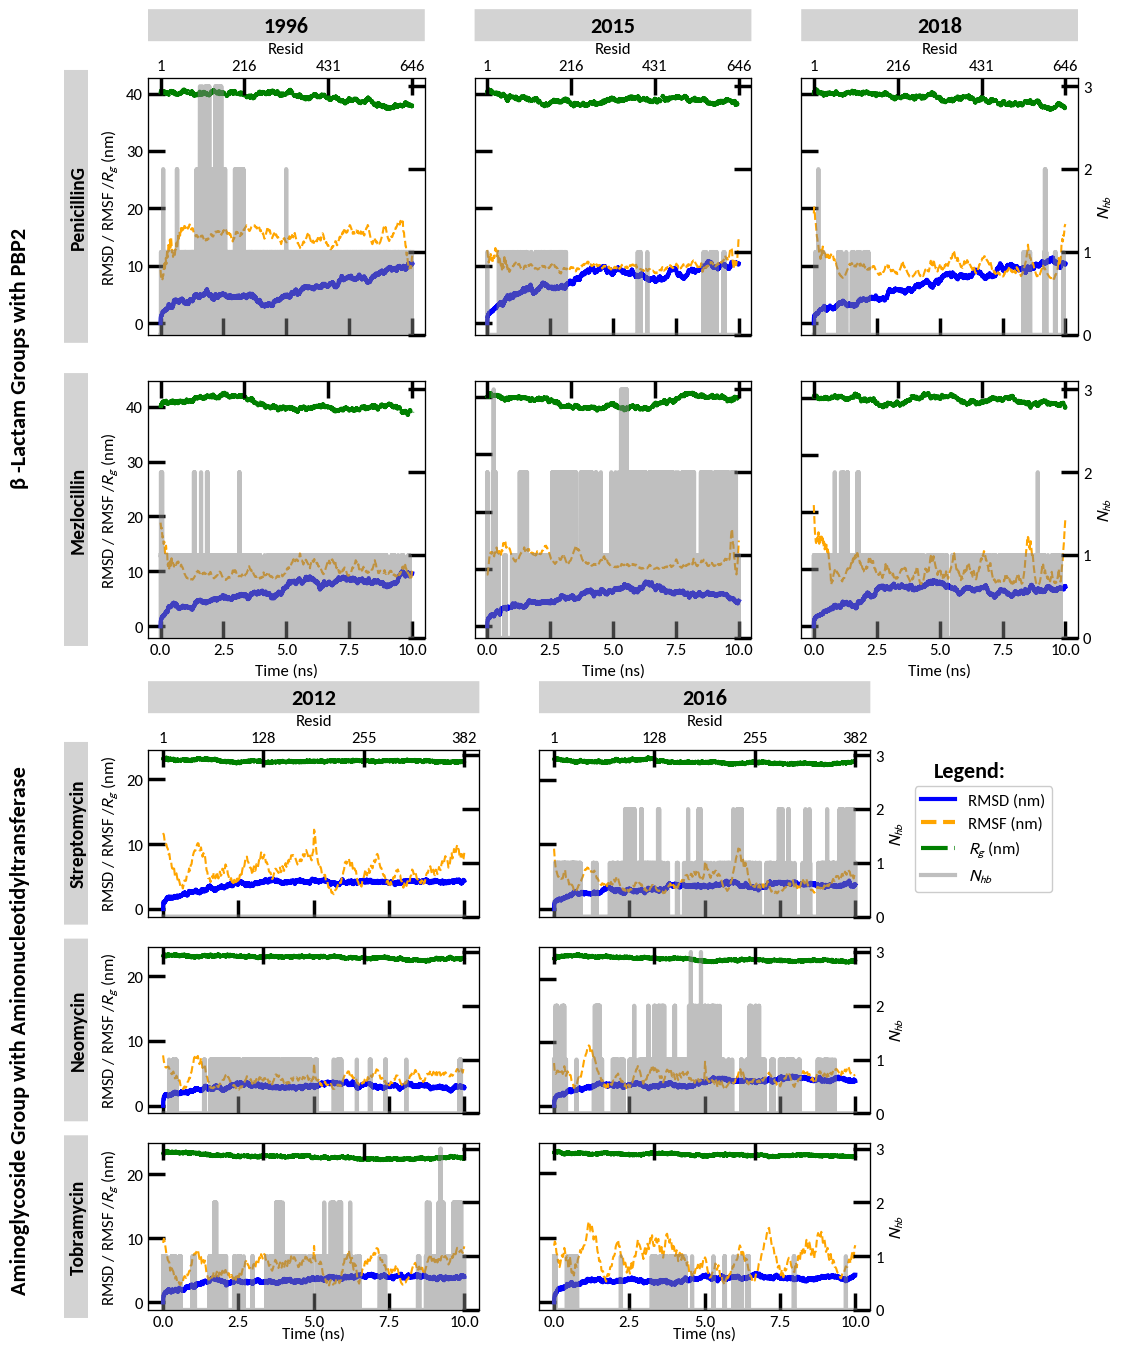

In [14]:
# language: python
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['axes.titlepad'] = 0
mpl.rcParams['font.family'] = 'Carlito'
mpl.rcParams['font.serif'] = ['Carlito']
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'stixsans'
mpl.rcParams['text.usetex'] = False
from matplotlib.patches import FancyBboxPatch
from matplotlib import lines as mlines

fig = plt.figure(figsize=(12, 16), constrained_layout=True)
# Outer: left main area + right legend column
outer = GridSpec(nrows=2, ncols=2, width_ratios=[8, 2], wspace=0.06)

# Right legend / annotation column
legend_ax = fig.add_subplot(outer[1, 1])
legend_ax.cla()
legend_ax.set_axis_off()
legend_ax.text(0.2, 0.98, "Legend:", va='top', fontsize=16, weight='bold')
handles = [
    mlines.Line2D([0], [0], color=colors['rmsd'], lw=lw, linestyle=linestyles['rmsd']),
    mlines.Line2D([0], [0], color=colors['rmsf'], lw=lw, linestyle=linestyles['rmsf']),
    mlines.Line2D([0], [0], color=colors['rg'], lw=lw, linestyle=linestyles['rg']),
    mlines.Line2D([0], [0], color=colors['nhb'], lw=lw, alpha=0.5, linestyle=linestyles['nhb']),
]
labels = ["RMSD (nm)", "RMSF (nm)", r"$R_g$ (nm)", r"$N_{hb}$"]

leg = legend_ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.05, 0.95),
                    frameon=True, fontsize=12, title=None)
leg.get_frame().set_alpha(1.0)


top_gs = outer[0, :].subgridspec(nrows=2, ncols=3, hspace=0.18, wspace=0.18)
# Top block: 2 rows × 3 cols
top_axes = [[fig.add_subplot(top_gs[r, c]) for c in range(3)] for r in range(2)]

# Column headers for top block
top_years = ['1996', '2015', '2018']
for j, year in enumerate(top_years):
    pos = top_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.026
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

#Formatting for top block axes
for r in range(2):
    for c in range(3):
        ax = top_axes[r][c]
        # make ticks point inward and enable ticks on top/right (still control label visibility below)
        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False, length=12, width=2.5)
        # disable minor ticks on both axes
        ax.minorticks_off()
        # hide axis label text (tick labels) but keep tick marks
        if r == 1:
            ax.tick_params(axis='x', which='both', labelbottom=True)
            ax.xaxis.set_label_coords(0.5, -0.1)
            ax.set_xlabel('Time (ns)', fontsize=12)
        else:
            ax.tick_params(axis='x', which='both', labelbottom=False)    
        if c == 0:
            ax.tick_params(axis='y', which='both', labelleft=True)
        else:
            ax.tick_params(axis='y', which='both', labelleft=False)
        #ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# Vertical group labels (left side)
top_block_pos = top_axes[1][0].get_position()  # middle row of top block
# compute vertical centers from actual axes positions (fixes AttributeError)
top_positions = [top_axes[r][c].get_position() for r in range(len(top_axes)) for c in range(len(top_axes[0]))]
top_y0 = min(p.y0 for p in top_positions)
top_y1 = max(p.y1 for p in top_positions)
top_center = (top_y0 + top_y1) / 2
fig.text(0.01, top_center, "\u03B2 -Lactam Groups with PBP2",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')


Ligand_names = ["PenicillinG", "Mezlocillin"]
for i, name in enumerate(Ligand_names):
    pos = top_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.07, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.07, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.065, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')


#Data plots for top axes
pbppen_complexes = [name for name in complexes.keys() if 'pbppen' in name.lower()]
for i, cmplx, ax in zip(range(len(top_axes[0])), sorted(pbppen_complexes), top_axes[0]):
    setlabel = (i == len(top_axes[0]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel, top_ticklabel=True)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")

pbpmez_complexes = [name for name in complexes.keys() if 'pbpmez' in name.lower()]
for i, cmplx, ax in zip(range(len(top_axes[1])), sorted(pbpmez_complexes), top_axes[1]):
    setlabel = (i == len(top_axes[1]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")

# Bottom block: 3 rows × 2 cols
# make the bottom block span the full figure width (both left and legend columns)
bot_gs = outer[1, 0].subgridspec(nrows=3, ncols=2, hspace=0.18, wspace=0.18)
bot_axes = [[fig.add_subplot(bot_gs[r, c]) for c in range(2)] for r in range(3)]

# Column headers for bottom block
bot_years = ['2012', '2016']
for j, year in enumerate(bot_years):
    pos = bot_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.026
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

for r in range(3):
    for c in range(2):
        ax = bot_axes[r][c]
        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False, length=12, width=2.5)
        ax.minorticks_off()
        # hide axis label text (tick labels) but keep tick marks
        if r == 2:
            ax.tick_params(axis='x', which='both', labelbottom=True)
            # raise x-label a bit (move it slightly closer to the axis)
            ax.xaxis.set_label_coords(0.5, -0.1)
            ax.set_xlabel('Time (ns)', fontsize=12)
        else:
            ax.tick_params(axis='x', which='both', labelbottom=False)
        if c == 0:
            ax.tick_params(axis='y', which='both', labelleft=True)
        else:
            ax.tick_params(axis='y', which='both', labelleft=False)
        #ax.tick_params(axis='both', which='both', labelbottom=False, labelleft


bot_block_pos = bot_axes[1][0].get_position()  # middle row of bottom block
bot_positions = [bot_axes[r][c].get_position() for r in range(len(bot_axes)) for c in range(len(bot_axes[0]))]
bot_y0 = min(p.y0 for p in bot_positions)
bot_y1 = max(p.y1 for p in bot_positions)
bot_center = (bot_y0 + bot_y1) / 2
fig.text(0.01, bot_center, "Aminoglycoside Group with Aminonucleotidyltransferase",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')


Ligand_names = ["Streptomycin", "Neomycin" , "Tobramycin"]
for i, name in enumerate(Ligand_names):
    pos = bot_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.07, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.07, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.065, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')

aminostep_complexes = [name for name in complexes.keys() if 'aminostep' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[0])), sorted(aminostep_complexes), bot_axes[0]):
    setlabel = (i == len(bot_axes[0]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel, top_ticklabel=True)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")

aminoneo_complexes = [name for name in complexes.keys() if 'aminoneo' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[1])), sorted(aminoneo_complexes), bot_axes[1]):
    setlabel = (i == len(bot_axes[1]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")

aminotob_complexes = [name for name in complexes.keys() if 'aminotob' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[2])), sorted(aminotob_complexes), bot_axes[2]):
    setlabel = (i == len(bot_axes[2]) - 1)  # only set right y-tick labels on rightmost plot
    add_plot(cmplx, rmsd_df, ax, rmsf_dict, nhb_df, right_ticklabel=setlabel)
    if i == 0:
        ax.set_ylabel("RMSD / RMSF /" + r"$R_g$ (nm)")

plt.savefig("pseudomonas_antibiotics_pbp_amino.svg", dpi=300, bbox_inches='tight')
plt.show()

### Hydrogen Bond occupancy statistics

In [15]:
from tqdm.notebook import tqdm
hb_details = {}

for complex, hb in tqdm(hb_dict.items()):
    u = complexes[complex]
    ligand_indices = u.select_atoms('not protein').indices
    ligand_names = u.select_atoms('not protein').resnames
    hbstats = hb.count_by_ids()
    # Only keep bonds with occupancy more than 0.1%
    hbstats_filtered = hbstats[hbstats[:, -1] / hb.n_frames > 0.001]
    bond_types = []
    for bond in hbstats_filtered:
        donor_idx, hydrogen_idx, acceptor_idx, occ = bond
        donor_atom = u.atoms[int(donor_idx)]
        hydrogen_atom = u.atoms[int(hydrogen_idx)]
        acceptor_atom = u.atoms[int(acceptor_idx)]
        # Check if the donor or acceptor is a ligand
        if donor_idx in ligand_indices and acceptor_idx not in ligand_indices:
            # Donor is a ligand, acceptor is not
            bond_type = f"({donor_atom.resname}){donor_atom.name}-H::{acceptor_atom.name}({acceptor_atom.resid}-{acceptor_atom.resname}) : {occ/hb.n_frames:.3f}"
        elif acceptor_idx in ligand_indices and donor_idx not in ligand_indices:
            # Acceptor is a ligand, donor is not
            bond_type = f"({donor_atom.resid}-{donor_atom.resname}){donor_atom.name}-H::{acceptor_atom.name}({acceptor_atom.resname}) : {occ/hb.n_frames:.3f}"
        else:
            # Both donor and acceptor are ligands
            continue
        bond_types.append(bond_type)
    
    hb_details[complex] = bond_types

  0%|          | 0/36 [00:00<?, ?it/s]

### Save the hydrogen bond data to a json file so you don't have to keep calculating it

In [16]:
import json

outpath = os.path.join(data_dir, "hb_details.json")
with open(outpath, "w") as fh:
    json.dump(hb_details, fh, indent=2)
print(f"Saved hb_details to {outpath}")

Saved hb_details to /home/admin/gitrepos/gromacs_sims/Antimicrobial_Peptides/Pseudomonas_antibiotics/simulation/new_parc_simulation_complexes_kuhpchn/hb_details.json


### Load the hbonds info from json file to plot

In [17]:
import json
from pprint import pprint
import os
import re
import pandas as pd
from IPython.display import display

hb_json_path = "/home/admin/gitrepos/gromacs_sims/Antimicrobial_Peptides/Pseudomonas_antibiotics/simulation/new_parc_simulation_complexes_kuhpchn/hb_details.json"

if not os.path.exists(hb_json_path):
    raise FileNotFoundError(f"Hydrogen-bond JSON not found: {hb_json_path}")

with open(hb_json_path, "r") as fh:
    hb_details_loaded = json.load(fh)

print(f"Loaded {len(hb_details_loaded)} complexes from {hb_json_path}")
# build a hierarchical (MultiIndex) table from hb_details_loaded

rows = []
for complex_name, bonds in hb_details_loaded.items():
    if not bonds:
        rows.append({
            'complex': complex_name,
            'bond_idx': 0,
            'bond_str': '',
            'donor_resid': None,
            'donor_resname': None,
            'donor_atom': None,
            'acceptor_atom': None,
            'acceptor_resname': None,
            'occupancy': None,
        })
        continue
    for i, b in enumerate(bonds):
        if not b or not b.strip():
            continue
        m = re.match(
            r'\((?P<don_resid>\d+)-(?P<don_resname>[^)]+)\)'
            r'(?P<don_atom>[^-]+)-H::(?P<acc_atom>[^(]+)\('
            r'(?P<acc_resname>[^)]+)\)\s*:\s*(?P<occ>[\d.]+)',
            b
        )
        if m:
            gd = m.groupdict()
            rows.append({
                'complex': complex_name,
                'bond_idx': i,
                'bond_str': b,
                'donor_resid': int(gd['don_resid']),
                'donor_resname': gd['don_resname'],
                'donor_atom': gd['don_atom'],
                'acceptor_atom': gd['acc_atom'].strip(),
                'acceptor_resname': gd['acc_resname'],
                'occupancy': float(gd['occ'])
            })
        else:
            # fallback: keep raw string and split off trailing occupancy if present
            parts = [p.strip() for p in b.rsplit(":", 1)]
            occ = None
            if len(parts) == 2:
                try:
                    occ = float(parts[1])
                except Exception:
                    occ = None
            rows.append({
                'complex': complex_name,
                'bond_idx': i,
                'bond_str': b,
                'donor_resid': None,
                'donor_resname': None,
                'donor_atom': None,
                'acceptor_atom': None,
                'acceptor_resname': None,
                'occupancy': occ
            })

df_hb = pd.DataFrame(rows)
df_hb.set_index(['complex', 'bond_idx'], inplace=True, drop=True)
# sort for nicer display
df_hb.sort_index(inplace=True)

# show the hierarchical table
display(df_hb)

out_xlsx = os.path.join(os.path.dirname(hb_json_path), "hb_details.xlsx")
os.makedirs(os.path.dirname(out_xlsx), exist_ok=True)
try:
    df_hb.to_excel(out_xlsx, sheet_name="hbonds")
    print(f"Saved hb dataframe to {out_xlsx}")
except Exception as e:
    print(f"Failed to save Excel file: {e}")

Loaded 36 complexes from /home/admin/gitrepos/gromacs_sims/Antimicrobial_Peptides/Pseudomonas_antibiotics/simulation/new_parc_simulation_complexes_kuhpchn/hb_details.json


bond_str  donor_resid  \
complex       bond_idx                                                 
aminoneo2012C 0           (26-SER)OG-H::N4(NEO) : 0.002         26.0   
              1           (90-SER)OG-H::N2(NEO) : 0.010         90.0   
              2          (93-THR)OG1-H::N2(NEO) : 0.006         93.0   
              3         (100-THR)OG1-H::N4(NEO) : 0.136        100.0   
aminoneo2016C 0          (19-ARG)NH2-H::N2(NEO) : 0.001         19.0   
...                                                 ...          ...   
pbppen2018C   0         (369-ARG)NH2-H::O1(PEN) : 0.001        369.0   
              1         (452-GLN)NE2-H::O1(PEN) : 0.001        452.0   
              2         (541-THR)OG1-H::O1(PEN) : 0.002        541.0   
              3         (541-THR)OG1-H::O3(PEN) : 0.002        541.0   
              4         (543-GLN)NE2-H::O3(PEN) : 0.003        543.0   

                       donor_resname donor_atom acceptor_atom  \
complex       bond_idx                                          
aminoneo2012C 0                  SER         OG            N4   
              1                  SER         OG            N2   
              2                  THR        OG1            N2   
              3                  THR        OG1            N4   
aminoneo2016C 0                  ARG        NH2            N2   
...                              ...        ...           ...   
pbppen2018C   0                  ARG        NH2            O1   
              1                  GLN        NE2            O1   
              2                  THR        OG1            O1   
              3                  THR        OG1            O3   
              4                  GLN        NE2            O3   

                       acceptor_resname  occupancy  
complex       bond_idx                              
aminoneo2012C 0                     NEO      0.002  
              1                     NEO      0.010  
              2                     NEO      0.006  
              3                     NEO      0.136  
aminoneo2016C 0                     NEO      0.001  
...                                 ...        ...  
pbppen2018C   0                     PEN      0.001  
              1                     PEN      0.001  
              2                     PEN      0.002  
              3                     PEN      0.002  
              4                     PEN      0.003  

[133 rows x 7 columns]

Failed to save Excel file: No module named 'openpyxl'


## Plot everything

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Gantt-style horizontal bars for bonds, with the bond string displayed inside each bar
def plot_gantt(axis, bond_list, set_xlabel=False, xlim=(-0.01, 0.75)):
    # parse labels and occupancies
    labels = [b.split(" : ")[0] for b in bond_list]
    occs = np.array([float(b.split(" : ")[1]) for b in bond_list])

    # sort by occupancy descending for nicer layout
    order = np.argsort(-occs)
    labels = [labels[i] for i in order]
    occs = occs[order]

    y = np.arange(len(labels))
    bars = axis.barh(y, occs, color='lightblue', edgecolor='black', height=1)

    # put the bond string inside each bar (or just to the right if bar too small)
    for idx, (bar, lbl, val) in enumerate(zip(bars, labels, occs)):
        width = bar.get_width()
        x_text = width * 0.5
        # decide text color for contrast
        text_color = "black"
        if width < 0.3:
            # place label just right of the bar for very small bars
            x_text = width + 0.005
            ha = "left"
        else:
            ha = "center"
        axis.text(x_text, bar.get_y() + bar.get_height() / 2, lbl, va="center", ha=ha, color=text_color, fontsize=7, clip_on=True)
    
    if set_xlabel:
        axis.set_xlabel("Occupancy (fraction)")
    else:
        #Turn off all ticks
        axis.set_xticklabels([])

    axis.set_xlim(xlim)
    axis.set_yticks([])
    axis.set_yticklabels([])  # labels are shown inside bars
    ymin, ymax = axis.get_ylim()
    axis.set_ylim(ymin - 0.5, ymax + 0.5)
    axis.invert_yaxis()  # highest occupancy at top (optional)


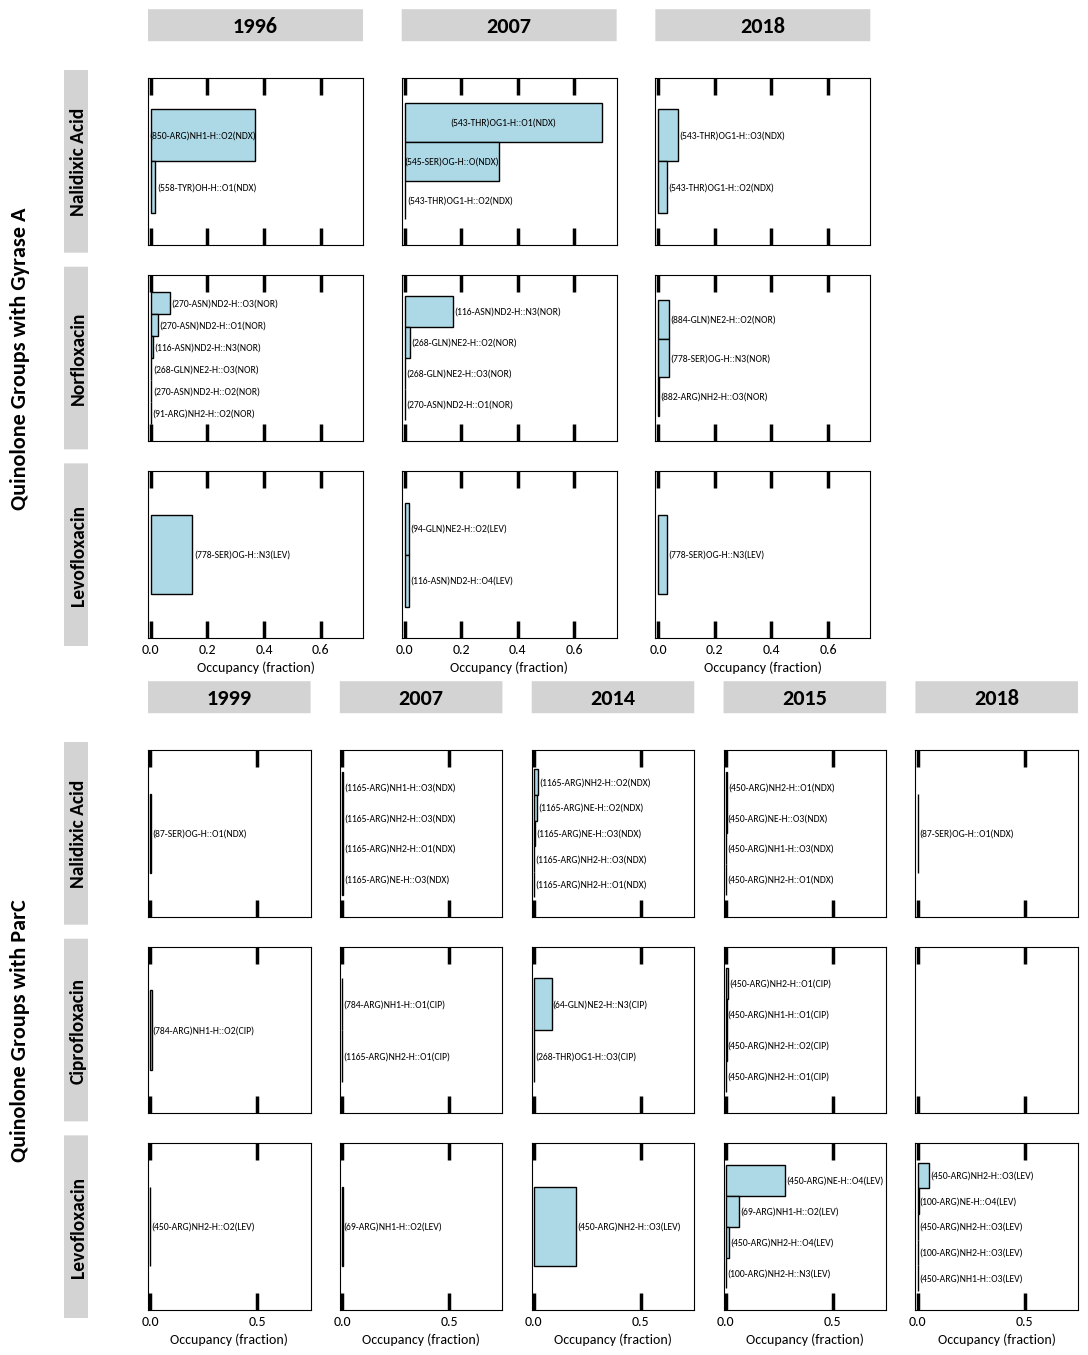

In [19]:
# language: python
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['axes.titlepad'] = 0
mpl.rcParams['font.family'] = 'Carlito'
mpl.rcParams['font.serif'] = ['Carlito']
mpl.rcParams['font.size'] = 10
mpl.rcParams['mathtext.fontset'] = 'stixsans'
mpl.rcParams['text.usetex'] = False
from matplotlib.patches import FancyBboxPatch
from matplotlib import lines as mlines

fig = plt.figure(figsize=(12, 16), constrained_layout=True)
# Outer: left main area + right legend column
outer = GridSpec(nrows=2, ncols=2, width_ratios=[8, 2], wspace=0.06)

# Right legend / annotation column
legend_ax = fig.add_subplot(outer[0, 1])
legend_ax.cla()
legend_ax.set_axis_off()


top_gs = outer[0, 0].subgridspec(nrows=3, ncols=3, hspace=0.18, wspace=0.18)
# Top block: 3 rows × 3 cols
top_axes = [[fig.add_subplot(top_gs[r, c]) for c in range(3)] for r in range(3)]

# Column headers for top block
top_years = ['1996', '2007', '2018']
for j, year in enumerate(top_years):
    pos = top_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.026
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

#Formatting for top block axes
for r in range(3):
    for c in range(3):
        ax = top_axes[r][c]
        # make ticks point inward and enable ticks on top/right (still control label visibility below)
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=False, length=12, width=2.5)
        # disable minor ticks on both axes
        ax.minorticks_off()
        

# Vertical group labels (left side)
top_block_pos = top_axes[1][0].get_position()  # middle row of top block
# compute vertical centers from actual axes positions (fixes AttributeError)
top_positions = [top_axes[r][c].get_position() for r in range(len(top_axes)) for c in range(len(top_axes[0]))]
top_y0 = min(p.y0 for p in top_positions)
top_y1 = max(p.y1 for p in top_positions)
top_center = (top_y0 + top_y1) / 2
fig.text(0.01, top_center, "Quinolone Groups with Gyrase A",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')

Ligand_names = ["Nalidixic Acid", "Norfloxacin", "Levofloxacin"]
for i, name in enumerate(Ligand_names):
    pos = top_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.07, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.07, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.065, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')


#Data plots for top axes
ndxgyra_complexes = [name for name in hb_details_loaded.keys() if 'ndxgyra' in name.lower()]
for i, cmplx, ax in zip(range(len(top_axes[0])), sorted(ndxgyra_complexes), top_axes[0]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=False,xlim=(-0.01, 0.75))
    
norgyra_complexes = [name for name in hb_details_loaded.keys() if 'norgyra' in name.lower()]
for i, cmplx, ax in zip(range(len(top_axes[1])), sorted(norgyra_complexes), top_axes[1]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=False,xlim=(-0.01, 0.75))

levgyra_complexes = [name for name in hb_details_loaded.keys() if 'levgyra' in name.lower()]
for i, cmplx, ax in zip(range(len(top_axes[2])), sorted(levgyra_complexes), top_axes[2]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=True,xlim=(-0.01, 0.75))

# Bottom block: 3 rows × 5 cols
# make the bottom block span the full figure width (both left and legend columns)
bot_gs = outer[1, :].subgridspec(nrows=3, ncols=5, hspace=0.18, wspace=0.18)
bot_axes = [[fig.add_subplot(bot_gs[r, c]) for c in range(5)] for r in range(3)]

# Column headers for bottom block
bot_years = ['1999', '2007', '2014', '2015', '2018']
for j, year in enumerate(bot_years):
    pos = bot_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.026
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

for r in range(3):
    for c in range(5):
        ax = bot_axes[r][c]
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=False, length=12, width=2.5)
        ax.minorticks_off()



bot_block_pos = bot_axes[1][0].get_position()  # middle row of bottom block
bot_positions = [bot_axes[r][c].get_position() for r in range(len(bot_axes)) for c in range(len(bot_axes[0]))]
bot_y0 = min(p.y0 for p in bot_positions)
bot_y1 = max(p.y1 for p in bot_positions)
bot_center = (bot_y0 + bot_y1) / 2
fig.text(0.01, bot_center, "Quinolone Groups with ParC",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')


Ligand_names = ["Nalidixic Acid", "Ciprofloxacin", "Levofloxacin"]
for i, name in enumerate(Ligand_names):
    pos = bot_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.07, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.07, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.065, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')

ndxparc_complexes = [name for name in hb_details_loaded.keys() if 'ndxparc' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[0])), sorted(ndxparc_complexes), bot_axes[0]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=False,xlim=(-0.01, 0.75))

cipparc_complexes = [name for name in hb_details_loaded.keys() if 'cipparc' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[1])), sorted(cipparc_complexes), bot_axes[1]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=False,xlim=(-0.01, 0.75))

levparc_complexes = [name for name in hb_details_loaded.keys() if 'levparc' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[2])), sorted(levparc_complexes), bot_axes[2]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=True,xlim=(-0.01, 0.75))

plt.savefig("hbonds_pseudomonas_antibiotics_gyra_parc.svg", dpi=300, bbox_inches='tight')
plt.show()

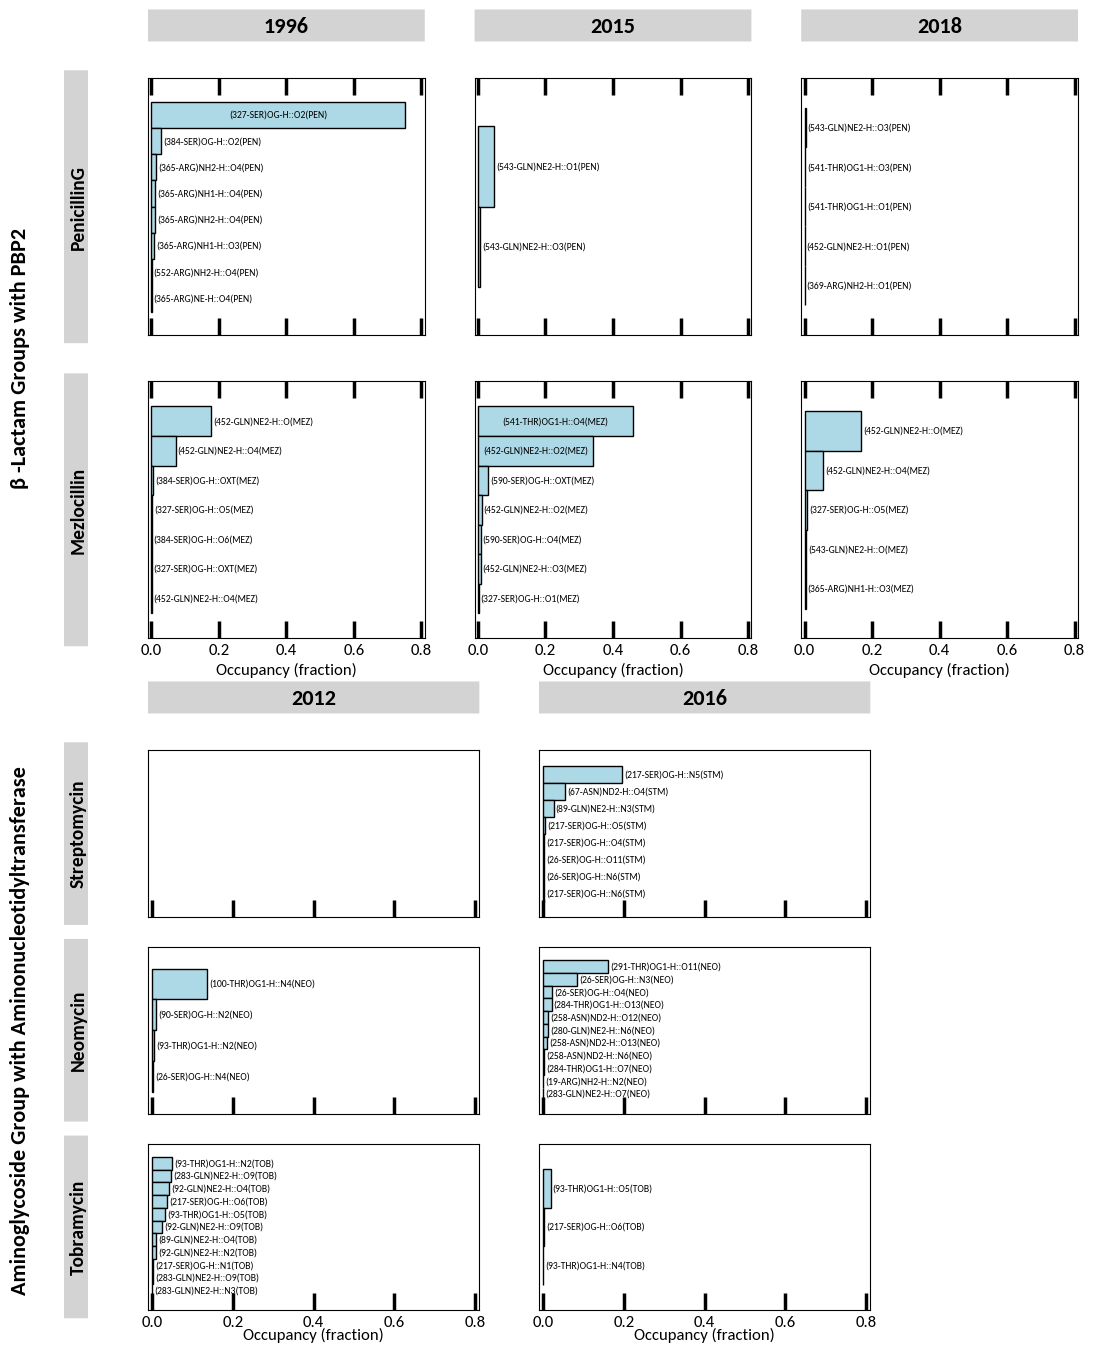

In [20]:
# language: python
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['axes.titlepad'] = 0
mpl.rcParams['font.family'] = 'Carlito'
mpl.rcParams['font.serif'] = ['Carlito']
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'stixsans'
mpl.rcParams['text.usetex'] = False
from matplotlib.patches import FancyBboxPatch
from matplotlib import lines as mlines

fig = plt.figure(figsize=(12, 16), constrained_layout=True)
# Outer: left main area + right legend column
outer = GridSpec(nrows=2, ncols=2, width_ratios=[8, 2], wspace=0.06)

# Right legend / annotation column
legend_ax = fig.add_subplot(outer[1, 1])
legend_ax.cla()
legend_ax.set_axis_off()



top_gs = outer[0, :].subgridspec(nrows=2, ncols=3, hspace=0.18, wspace=0.18)
# Top block: 2 rows × 3 cols
top_axes = [[fig.add_subplot(top_gs[r, c]) for c in range(3)] for r in range(2)]

# Column headers for top block
top_years = ['1996', '2015', '2018']
for j, year in enumerate(top_years):
    pos = top_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.026
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

#Formatting for top block axes
for r in range(2):
    for c in range(3):
        ax = top_axes[r][c]
        # make ticks point inward and enable ticks on top/right (still control label visibility below)
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=False, length=12, width=2.5)
        # disable minor ticks on both axes
        ax.minorticks_off()
        

# Vertical group labels (left side)
top_block_pos = top_axes[1][0].get_position()  # middle row of top block
# compute vertical centers from actual axes positions (fixes AttributeError)
top_positions = [top_axes[r][c].get_position() for r in range(len(top_axes)) for c in range(len(top_axes[0]))]
top_y0 = min(p.y0 for p in top_positions)
top_y1 = max(p.y1 for p in top_positions)
top_center = (top_y0 + top_y1) / 2
fig.text(0.01, top_center, "\u03B2 -Lactam Groups with PBP2",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')


Ligand_names = ["PenicillinG", "Mezlocillin"]
for i, name in enumerate(Ligand_names):
    pos = top_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.07, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.07, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.065, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')


#Data plots for top axes
pbppen_complexes = [name for name in hb_details_loaded.keys() if 'pbppen' in name.lower()]
for i, cmplx, ax in zip(range(len(top_axes[0])), sorted(pbppen_complexes), top_axes[0]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=False,xlim=(-0.01, 0.81))

pbpmez_complexes = [name for name in hb_details_loaded.keys() if 'pbpmez' in name.lower()]
for i, cmplx, ax in zip(range(len(top_axes[1])), sorted(pbpmez_complexes), top_axes[1]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=True,xlim=(-0.01, 0.81))

# Bottom block: 3 rows × 2 cols
# make the bottom block span the full figure width (both left and legend columns)
bot_gs = outer[1, 0].subgridspec(nrows=3, ncols=2, hspace=0.18, wspace=0.18)
bot_axes = [[fig.add_subplot(bot_gs[r, c]) for c in range(2)] for r in range(3)]

# Column headers for bottom block
bot_years = ['2012', '2016']
for j, year in enumerate(bot_years):
    pos = bot_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.026
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

for r in range(3):
    for c in range(2):
        ax = bot_axes[r][c]
        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False, length=12, width=2.5)
        ax.minorticks_off()
        # hide axis label text (tick labels) but keep tick marks
        if r == 2:
            ax.tick_params(axis='x', which='both', labelbottom=True)
            # raise x-label a bit (move it slightly closer to the axis)
            ax.xaxis.set_label_coords(0.5, -0.1)
            ax.set_xlabel('Time (ns)', fontsize=12)
        else:
            ax.tick_params(axis='x', which='both', labelbottom=False)
        if c == 0:
            ax.tick_params(axis='y', which='both', labelleft=True)
        else:
            ax.tick_params(axis='y', which='both', labelleft=False)
        #ax.tick_params(axis='both', which='both', labelbottom=False, labelleft


bot_block_pos = bot_axes[1][0].get_position()  # middle row of bottom block
bot_positions = [bot_axes[r][c].get_position() for r in range(len(bot_axes)) for c in range(len(bot_axes[0]))]
bot_y0 = min(p.y0 for p in bot_positions)
bot_y1 = max(p.y1 for p in bot_positions)
bot_center = (bot_y0 + bot_y1) / 2
fig.text(0.01, bot_center, "Aminoglycoside Group with Aminonucleotidyltransferase",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')


Ligand_names = ["Streptomycin", "Neomycin" , "Tobramycin"]
for i, name in enumerate(Ligand_names):
    pos = bot_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.07, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.07, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.065, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')

aminostep_complexes = [name for name in hb_details_loaded.keys() if 'aminostep' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[0])), sorted(aminostep_complexes), bot_axes[0]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=False,xlim=(-0.01, 0.81))

aminoneo_complexes = [name for name in hb_details_loaded.keys() if 'aminoneo' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[1])), sorted(aminoneo_complexes), bot_axes[1]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=False,xlim=(-0.01, 0.81))

aminotob_complexes = [name for name in hb_details_loaded.keys() if 'aminotob' in name.lower()]
for i, cmplx, ax in zip(range(len(bot_axes[2])), sorted(aminotob_complexes), bot_axes[2]):
    plot_gantt(ax, hb_details_loaded.get(cmplx, []), set_xlabel=True,xlim=(-0.01, 0.81))


plt.savefig("hbonds_pseudomonas_antibiotics_pbp_amino.svg", dpi=300, bbox_inches='tight')
plt.show()

# Notabene
The ligand in the `ndxgyra2007C` complex is labelled `NEO` (Neomycin), not `NDX` (Nalidixic acid) as expected. The wrong ligand was inserted. If the former, then manually alter the label. This simulation was repeated with the correct ligand.

## PDB snapshots of chosen simulations

In [7]:
complexnames = [os.path.basename(dir) for dir in simulation_dirs]

In [ ]:
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm
import numpy as np
import MDAnalysis as mda
import os

time_windows = [0.0, 0.25, 0.5, 0.75, 1.0]
#chosen_complexes = ['aminostep2012C','pbppen2015C', 'pbpmez2018C']
chosen_complexes = complexnames  # all complexes  
def _write_frame_task(args):
    cmplx, frac = args
    # locate directory for this complex
    dirpath = next((d for d in simulation_dirs if os.path.basename(d) == cmplx), None)
    if dirpath is None:
        return (cmplx, frac, False, f"directory for {cmplx} not found")

    try:
        topol_file = [f for f in os.listdir(dirpath) if f.endswith('protlig.tpr')][0]
        traj_file = [f for f in os.listdir(dirpath) if f.endswith('cluster_center_traj.xtc')][0]
    except IndexError:
        return (cmplx, frac, False, f"topol/traj not found in {dirpath}")

    topol_path = os.path.join(dirpath, topol_file)
    traj_path = os.path.join(dirpath, traj_file)

    try:
        u = mda.Universe(topol_path, traj_path)
    except Exception as e:
        return (cmplx, frac, False, f"failed to load Universe: {e}")

    times = getattr(u.trajectory, "times", None)
    if times is None:
        times = np.array([ts.time for ts in u.trajectory])
        # reset to first frame after iterating
        try:
            u.trajectory[0]
        except Exception:
            pass
    total_time = times[-1]
    target_time = frac * total_time
    idx = int(np.argmin(np.abs(times - target_time)))

    try:
        u.trajectory[idx]
        time_ns = times[idx] / 1000.0
        pdb_dir = os.path.join(simdir, "pdbs", cmplx)
        os.makedirs(pdb_dir, exist_ok=True)
        out_fn = os.path.join(pdb_dir, f"{cmplx}_t{time_ns:.2f}ns.pdb")
        os.makedirs(os.path.dirname(out_fn), exist_ok=True)
        u.atoms.write(out_fn)
        return (cmplx, frac, True, out_fn)
    except Exception as e:
        return (cmplx, frac, False, str(e))

# build tasks (one task per complex per time window) so progress shows per-file
tasks = [(c, f) for c in chosen_complexes for f in time_windows]

n_workers = max(1, min(nproc if 'nproc' in globals() else cpu_count(), cpu_count()))
n_workers = 3
results = []
with Pool(processes=n_workers) as pool:
    for res in tqdm(pool.imap_unordered(_write_frame_task, tasks), total=len(tasks)):
        results.append(res)
        cmplx, frac, ok, msg = res
        if ok:
            tqdm.write(f"Wrote {msg} for {cmplx} (frac={frac})")
        else:
            tqdm.write(f"Failed {cmplx} (frac={frac}): {msg}")

# optional: summary
successful = [r for r in results if r[2]]
failed = [r for r in results if not r[2]]
print(f"Wrote {len(successful)} files, {len(failed)} failures.")